In [66]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")


from IPython.display import display

import numpy as np
import networkx as nx
import qiskit
import sympy
from qiskit import transpile, QuantumCircuit

3534


None

benchmarklib.pipeline.synthesis.xag - DEBUG - Optimizing XAG...
benchmarklib.pipeline.synthesis.xag - DEBUG - Outputting XAG to tempfile /tmp/tmpru1r3u82
benchmarklib.pipeline.synthesis.xag - DEBUG - b'digraph {\nrankdir=BT;\n0 [label="0",shape=box,style=filled,fillcolor=snow2]\n1 [label="1",shape=triangle,style=filled,fillcolor=snow2]\n2 [label="2",shape=triangle,style=filled,fillcolor=snow2]\n3 [label="3",shape=triangle,style=filled,fillcolor=snow2]\n4 [label="4",shape=triangle,style=filled,fillcolor=snow2]\n5 [label="5",shape=triangle,style=filled,fillcolor=snow2]\n6 [label="6",shape=triangle,style=filled,fillcolor=snow2]\n7 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n8 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n9 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n10 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n11 [label="AND",shape=ellipse,style=filled,fillcolor=lightcoral]\n12 [label="AND",shape=ellipse,style=fil

False


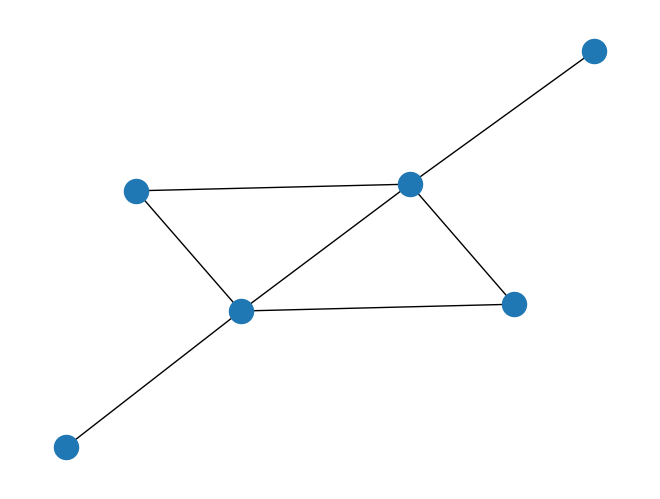

In [67]:
from benchmarklib.databases import CliqueDatabase
from benchmarklib.pipeline import PipelineCompiler
from benchmarklib.pipeline.synthesis import XAGSynthesizer
from benchmarklib import setup_logging
import logging
setup_logging(logging.DEBUG)

compiler = PipelineCompiler(XAGSynthesizer())

db = CliqueDatabase().shared()
clique_problem = db.get(3534)
print(clique_problem.instance_id)

G = nx.from_numpy_array(clique_problem.as_adjacency_matrix())
display(nx.draw(G))

result = compiler.compile(clique_problem, clique_size=3)
print(nx.is_bipartite(G))

('11', '12')
('11', '14')
('13', '14')


None

None

{'nodes_at_level': [6, 9, 5, 4, 4, 4, 3, 2, 2, 1], 'max_width_level': 1, 'max_width': 9, 'longest_path_len': 10, 'and_dist_by_level': [0, 6, 5, 2, 3, 2, 3, 2, 2, 1], 'xor_dist_by_level': [0, 3, 0, 2, 1, 2, 0, 0, 0, 0], 'and_count': 26, 'xor_count': 8, 'num_nodes': 42}


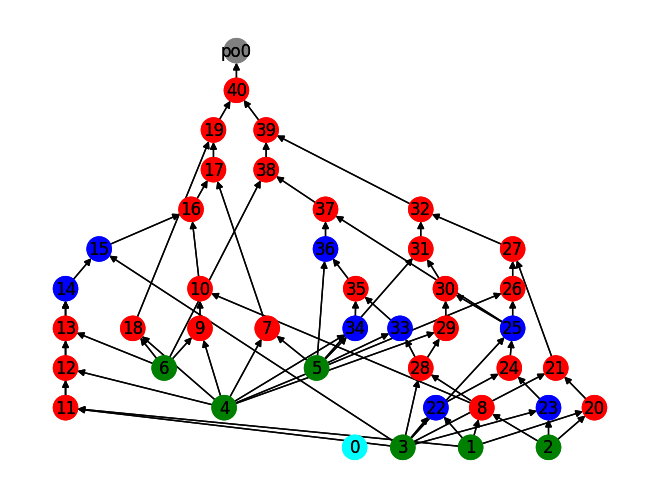

In [68]:
from nxag import PyXAG
import tempfile
import pygraphviz

nxag = result.artifacts['nxag']

for edge in nxag.edges(['11', '13']):
    print(edge)

py_xag = PyXAG().from_nx(nxag)

display(py_xag.draw())
py_xag.optimize_xag()
display(py_xag.draw())


print(py_xag.compute_graph_stats())


# ANF Cut via Simulated Annealing of k-feasible cuts

### Finding all cuts 

The cut we are looking for is a set of $k$ vertices that disconnect the input nodes from the root

Invalid XAG
Invalid XAG
all_cuts [frozenset({'17', '38', '32', '18'}), frozenset({'27', '38', '19', '31'}), frozenset({'39', '7', '18', '16'})]
CUT  frozenset({'17', '38', '32', '18'})
1 weakly connected components
CUT  frozenset({'27', '38', '19', '31'})
1 weakly connected components
CUT  frozenset({'39', '7', '18', '16'})
1 weakly connected components


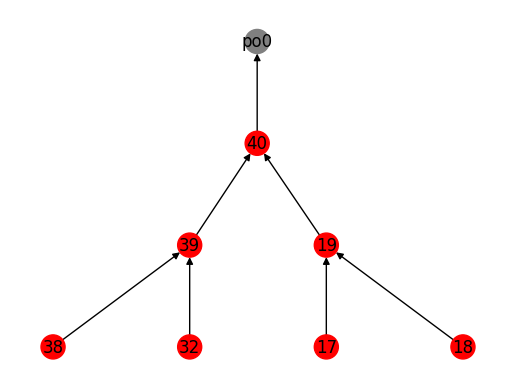

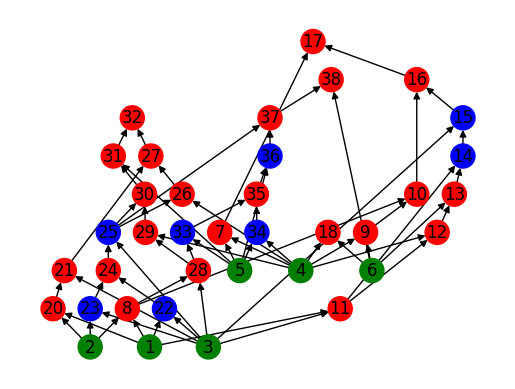

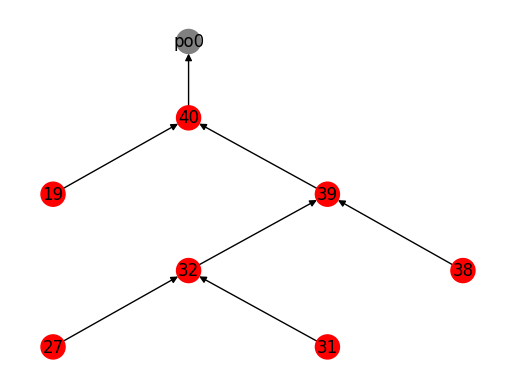

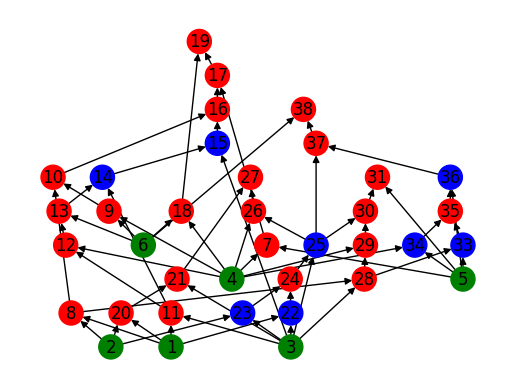

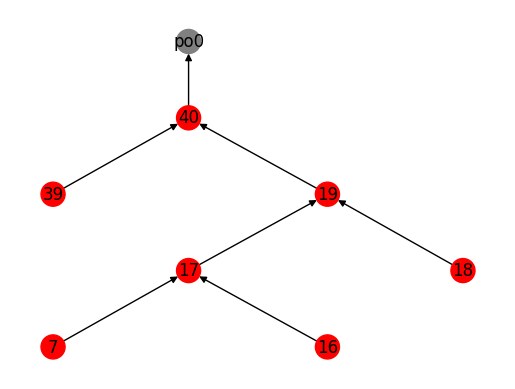

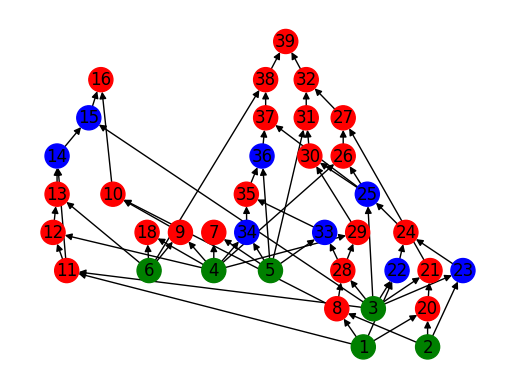

In [69]:
from collections import defaultdict
import matplotlib.pyplot as plt
# A cache (memoization table) is CRITICAL for performance.
# It stores results for subproblems we've already solved.
memo_cache = {}

def is_valid_xag_cut(pyxag, cut_set: frozenset, output_node: str) -> bool:
    """
    Checks if a cut creates a valid XAG subgraph.
    
    A cut is valid if for every node 'v' in the remaining subgraph (from the
    cut to the output), 'v' has either 0 or 2 of its parents in the cut_set.
    A node cannot have only 1 parent in the cut_set, as it would violate the
    2-input property for XAGs.
    """
    # Step 1: Find all nodes in the subgraph between the cut and the output.
    # We do a backwards traversal from the output, stopping at the cut frontier.
    subgraph_nodes = set()

    subgraph_nodes = set(cut_set)
    for node in cut_set:
        subgraph_nodes = subgraph_nodes.union(nx.descendants(py_xag.G, node))

    # Step 2: Check the parent condition for every node in the subgraph.
    for node in subgraph_nodes:
        # Primary inputs of the original graph don't need checking.
        if pyxag.G.in_degree(node) == 0 or 'po' in node:
            continue
            
        parents = set(pyxag.G.predecessors(node))
        
        # Find how many of this node's parents are in the subgraph.
        parents_in_cut = len(parents.intersection(subgraph_nodes))
        
        # A node is valid if it's fully internal (0 parents in cut) or
        # if it's a new primary input (2 parents in cut).
        # Having only 1 parent in the cut makes it an invalid dangling node.
        if parents_in_cut == 1:
            return False # Invalid cut!

    return True # All nodes passed the check.


def find_all_k_cuts_levelwise(pyxag, output_node: str, k: int):
    """
    Generate all k-cuts by exploring different "level sets" in the graph.
    This naturally handles asymmetric cuts.
    """
    all_cuts = []
    
    # Start with output node and expand backwards level by level
    current_frontiers = [frozenset([output_node])]
    visited_frontiers = set()
    
    while current_frontiers:
        frontier = current_frontiers.pop(0)
        
        # Skip if we've seen this frontier
        if frontier in visited_frontiers:
            continue
        visited_frontiers.add(frontier)
        
        # Check if this is a valid k-cut
        if len(frontier) == k:
            if is_valid_xag_cut(pyxag, frontier, output_node):
                all_cuts.append(frontier)
            else:
                print("Invalid XAG")
        
        # If frontier is too large, skip expansion
        if len(frontier) >= k:
            continue
        
        # Generate new frontiers by expanding different subsets of nodes
        expandable_nodes = [n for n in frontier if pyxag.G.in_degree(n) > 0]
        
        # Try expanding each subset of expandable nodes
        from itertools import combinations
        
        for r in range(1, len(expandable_nodes) + 1):
            for nodes_to_expand in combinations(expandable_nodes, r):
                new_frontier = set(frontier)
                
                # Remove nodes we're expanding
                for node in nodes_to_expand:
                    new_frontier.remove(node)
                    
                    # Add their parents
                    parents = pyxag.G.predecessors(node)
                    new_frontier.update(parents)
                
                new_frontier = frozenset(new_frontier)
                
                # Only add if size is within budget
                if len(new_frontier) <= k:
                    current_frontiers.append(new_frontier)
    
    return all_cuts

# --- How to use it ---

all_cuts = find_all_k_cuts_levelwise(py_xag, '40', 4)
print("all_cuts", all_cuts)

for cut in all_cuts:
    print("CUT ", cut)

    nodes_in_cut = set(cut)
    nodes_not_in_cut = set(cut)

    for node in cut:
        nodes_in_cut = nodes_in_cut.union(nx.descendants(py_xag.G, node))
        nodes_not_in_cut = nodes_not_in_cut.union(nx.ancestors(py_xag.G, node))

    subg_out = py_xag.G.subgraph(nodes_in_cut)
    subg_in = py_xag.G.subgraph(nodes_not_in_cut)

    for i, subg in enumerate([subg_out, subg_in]):
        pyxag_sub = PyXAG().from_nx(subg)
        fig, ax = plt.subplots()
        pyxag_sub.draw(ax=ax)
        if i == 1:
            weakly_connected = list(nx.weakly_connected_components(subg))
            print(f"{len(weakly_connected)} weakly connected components")


Find cost of each cut

Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
Invalid XAG
all_cuts [frozenset({'38', '31', '27', '7', '18', '16'}), frozenset({'21', '38', '31', '17', '26', '18'}), frozenset({'38', '15', '32', '7', '10', '18'})]
CUT  frozenset({'38', '31', '27', '7', '18', '16'})
x4 & x5 & x6 & ~(x1 & x2 & x3)
(x4 & x5 & x6) ^ (x1 & x2 & x3 & x4 & x5 & x6)

Cost 71
defaultdict(<class 'int'>, {'5': 8, '4': 19, '2': 19, '1': 24, '6': 8, '3': 22})
CUT  frozenset({'21', '38', '31', '17', '26', '18'})
x4 & x6 & ~(x1 & x2 & x3 & x5)
(x4 & x6) ^ (x1 & x2 & x3 & x4 & x5 & x6)

Cost 64
defaultdict(<class 'int'>, {'5': 9, '4': 19, '2': 19, '1': 24, '6': 9, '3': 22})
CUT  frozenset({'38', '15', '32', '7', '10', '18'})
x4 & x6 & ~(x1 & x3) & ~(x2 & x5)
(x4 & x6) ^

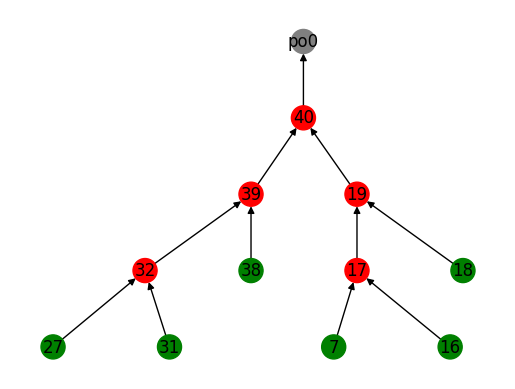

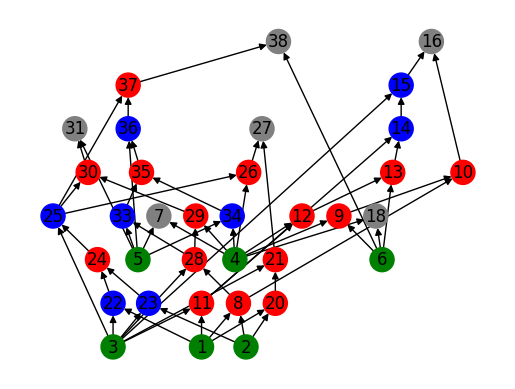

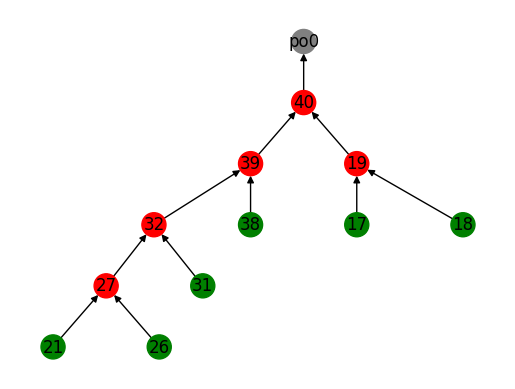

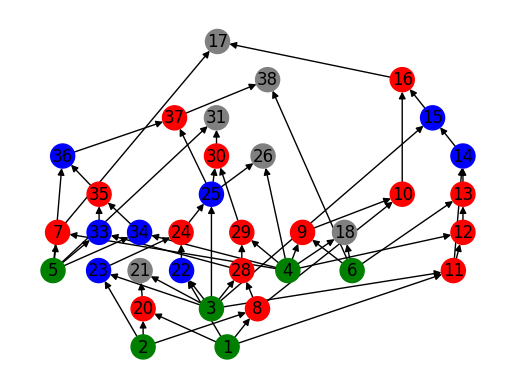

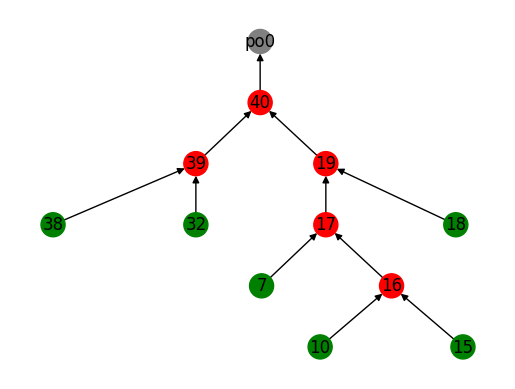

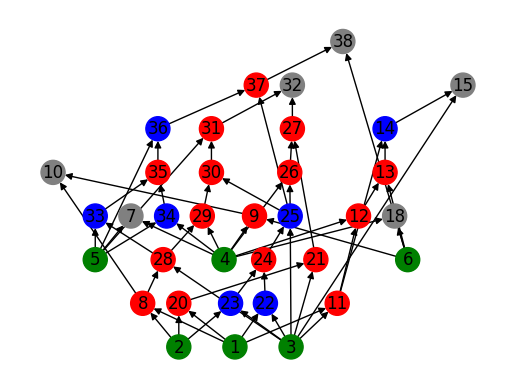

In [80]:
import matplotlib.pyplot as plt

def cost(expression):

    def T_cost(degree: int):
        match degree:
            case 0: 
                return -0.1
            case 2: 
                return 0
            case 3: 
                return 7
            case 4: 
                return 16
            case _:  
                return 2**degree

    print(expression)
    anf = expression.to_anf()
    print(anf)

    cost = 0

    for clause in anf.args:
        cost += T_cost(len(clause.args))
    print()

    return cost

# --- How to use it ---
#for k in [3, 4, 5, 6]:
for k in [6]:


    all_cuts = find_all_k_cuts_levelwise(py_xag, '40', k)
    print("all_cuts", all_cuts)

    for cut in all_cuts:
        print("CUT ", cut)

        nodes_in_cut = set(cut)
        nodes_not_in_cut = set(cut)

        for node in cut:
            nodes_in_cut = nodes_in_cut.union(nx.descendants(py_xag.G, node))
            nodes_not_in_cut = nodes_not_in_cut.union(nx.ancestors(py_xag.G, node))

        subg_out = py_xag.G.subgraph(nodes_in_cut)
        subg_in = py_xag.G.subgraph(nodes_not_in_cut)

        for i, subg in enumerate([subg_out, subg_in]):
            pyxag_sub = PyXAG().from_nx(subg.copy())

            if i == 0:
                for i, node in enumerate(cut):
                    pyxag_sub.G.nodes[node]['label'] = f"input{i + 1}"
                    pyxag_sub.G.nodes[node]['color'] = "green"
                
                expr = pyxag_sub.sympy_expr()

                try:
                    print("Cost", cost(expr))
                except:
                    print("Expr", expr)
            if i == 1:
                for node in cut:
                    pyxag_sub.G.nodes[node]['color'] = "gray"
                #weakly_connected = list(nx.weakly_connected_components(subg))
                #print(f"{len(weakly_connected)} weakly connected components")
                dependencies = defaultdict(int)
                for node in subg:
                    if subg.in_degree(node) >= 0:
                        input_ancestors = nx.ancestors(subg, node).intersection(pyxag_sub.input_nodes)
                        for input in input_ancestors:
                            dependencies[input] +=1
                print(dependencies)

            fig, ax = plt.subplots()
            pyxag_sub.draw(ax=ax)


## Exploring Cuts

In [71]:
# exploring cuts
import matplotlib.pyplot as plt

from copy import deepcopy

print(py_xag2.compute_graph_stats())


def cost(expression):

    def T_cost(degree: int):
        match degree:
            case 0: 
                return -0.1
            case 2: 
                return 0
            case 3: 
                return 7
            case 4: 
                return 16
            case _:  
                return 2**degree

    print(expression)
    anf = expression.to_anf()
    print(anf)

    cost = 0

    for clause in anf.args:
        cost += T_cost(len(clause.args))
    print()

    return cost

verts_in_cut = set()

# this loop gave us level 5 as best cut
for lvl, nodes in reversed(sorted(py_xag2.nodes_at_level.items())):
    
    print("\n", "="*30)
    print("ANF Cut for Level", lvl, ":", py_xag2.nodes_at_level[5])

    verts_in_cut.update(nodes)

    if lvl == py_xag2.longest_path:
        continue # ignore 'po0' level

    # make subgraph of the cut, 
    pyxag_sub = PyXAG().from_nx(py_xag2.G.subgraph(verts_in_cut))

    # fill in input gaps
    nodes_to_add = []
    for node in pyxag_sub.G.nodes:
        # if a node has degree 1 then it is missing an input (if its not po0)
        if node != 'po0' and pyxag_sub.G.in_degree(node) == 1:
            # check original graph for edges into this node
            for e in py_xag2.G.in_edges(node):
                # add any inputs to this node to the subgraph
                if e[0] not in pyxag_sub.G.nodes:
                    nodes_to_add.append(e[0])

    verts_in_cut.update(nodes_to_add)
    pyxag_sub.G = deepcopy(py_xag2.G.subgraph(verts_in_cut))

    # collect new input nodes
    new_inputs = []
    for node in pyxag_sub.G.nodes:
        if pyxag_sub.G.in_degree(node) == 0:
            new_inputs.append(node)

    print("New inputs", new_inputs)

    for i, node in enumerate(new_inputs):
        pyxag_sub.G.nodes[node]['label'] = f"input{i + 1}"
        pyxag_sub.G.nodes[node]['color'] = "green"

    pyxag_sub = PyXAG().from_nx(pyxag_sub.G)
    fig, ax = plt.subplots()
    pos = nx.drawing.nx_agraph.graphviz_layout(pyxag_sub.G, prog='dot')
    nx.draw(pyxag_sub.G, pos, node_color=pyxag_sub.color_map, with_labels=True, ax=ax)
    expr = pyxag_sub.sympy_expr()

    try:
        print("Cost", cost(expr))
    except:
        print("Expr", expr)
    
    print()

NameError: name 'py_xag2' is not defined

## Making Cut and sub-expressions

{'max_width_level': 0, 'max_width': 6, 'longest_path_len': 9, 'and_dist_by_level': [0, 3, 2, 2, 0, 2, 0, 1, 0], 'xor_dist_by_level': [0, 2, 1, 0, 2, 0, 1, 0, 1], 'and_count': 10, 'xor_count': 7, 'num_nodes': 25}
ANF Cut for Level 5 : ['19', '20']
New inputs ['20', '19', '6', '14']
20 {'label': 'AND', 'color': 'red'}
19 {'label': 'AND', 'color': 'red'}
6 {'label': 'input6', 'color': 'green'}
14 {'label': 'AND', 'color': 'red'}


None

x4 ^ (x2 & ~(x1 ^ x3))
x2 ^ x4 ^ (x1 & x2) ^ (x2 & x3)

Cost -0.2
Computing ancestors of  20
Subgraph Expr (x5 ^ x6) & ~(x6 ^ (x1 & x2 & x3 & x4))
Computing ancestors of  19
Subgraph Expr ~(~x1 & ~x2) & ~(x4 ^ ((x3 ^ x4) & ~(x4 ^ (x1 & x2))))
Computing ancestors of  6
Subgraph Expr x6
Computing ancestors of  14
Subgraph Expr ~(x1 & x2) & ~(x2 & x6)


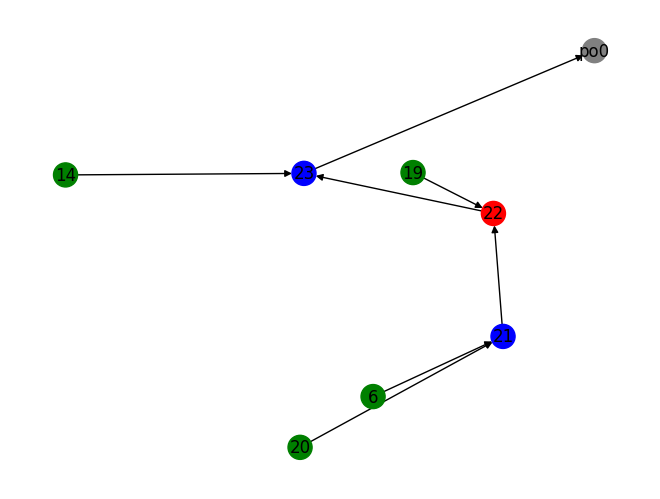

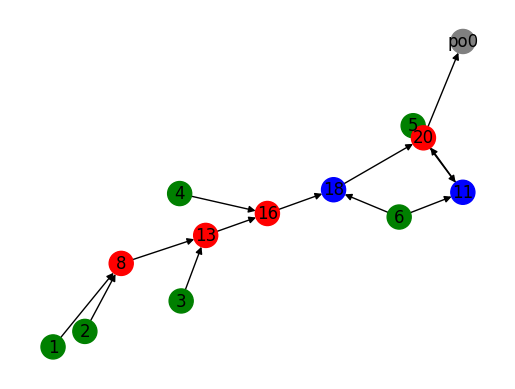

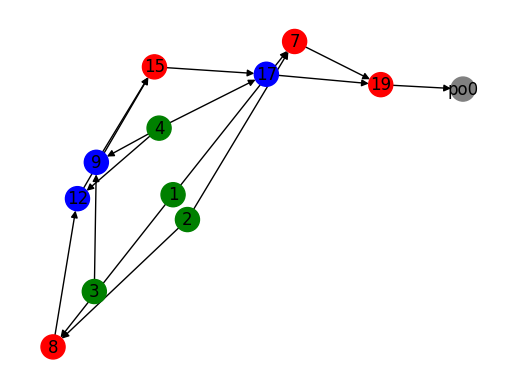

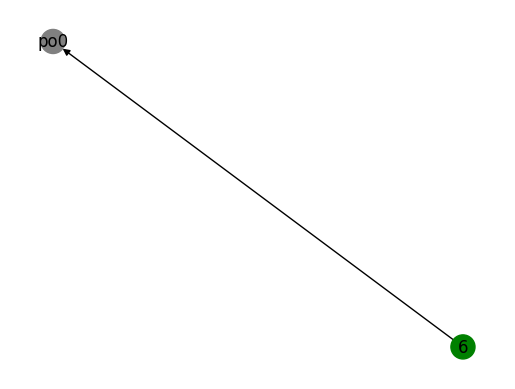

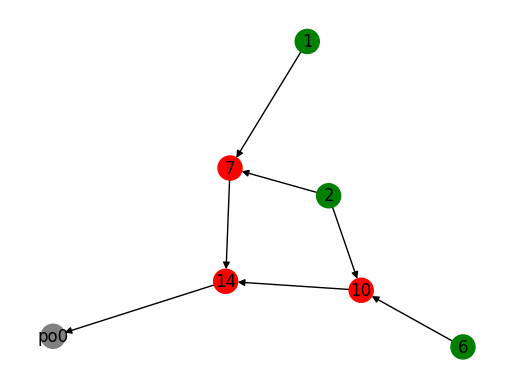

In [ ]:
import matplotlib.pyplot as plt

from copy import deepcopy

print(py_xag2.compute_graph_stats())


def cost(expression):

    def T_cost(degree: int):
        match degree:
            case 0: 
                return -0.1
            case 2: 
                return 0
            case 3: 
                return 7
            case 4: 
                return 16
            case _:  
                return 2**degree

    print(expression)
    anf = expression.to_anf()
    print(anf)

    cost = 0

    for clause in anf.args:
        cost += T_cost(len(clause.args))
    print()

    return cost

verts_in_cut = set()

# this loop gave us level 5 as best cut
#for lvl, nodes in reversed(sorted(py_xag2.nodes_at_level.items())):

lvl = 5
for level in range(5, py_xag2.longest_path+1):
    verts_in_cut.update(py_xag2.nodes_at_level[level])

    
print("ANF Cut for Level", lvl, ":", py_xag2.nodes_at_level[5])


# if lvl == py_xag2.longest_path:
#     continue # ignore 'po0' level

# make subgraph of the cut, 
pyxag_sub = PyXAG().from_nx(py_xag2.G.subgraph(verts_in_cut))

# fill in input gaps
nodes_to_add = []
for node in pyxag_sub.G.nodes:
    # if a node has degree 1 then it is missing an input (if its not po0)
    if node != 'po0' and pyxag_sub.G.in_degree(node) == 1:
        # check original graph for edges into this node
        for e in py_xag2.G.in_edges(node):
            # add any inputs to this node to the subgraph
            if e[0] not in pyxag_sub.G.nodes:
                nodes_to_add.append(e[0])

verts_in_cut.update(nodes_to_add)
pyxag_sub.G = deepcopy(py_xag2.G.subgraph(verts_in_cut))

# collect new input nodes
new_inputs = []
for node in pyxag_sub.G.nodes:
    if pyxag_sub.G.in_degree(node) == 0:
        new_inputs.append(node)

print("New inputs", new_inputs)
for node in new_inputs:
    print(node, py_xag2.G.nodes[node])

for i, node in enumerate(new_inputs):
    pyxag_sub.G.nodes[node]['label'] = f"input{i + 1}"
    pyxag_sub.G.nodes[node]['color'] = "green"

pyxag_sub = PyXAG().from_nx(pyxag_sub.G)
display(nx.draw(pyxag_sub.G, node_color=pyxag_sub.color_map, with_labels=True))
expr = pyxag_sub.sympy_expr()

try:
    print("Cost", cost(expr))
except:
    print("Expr", expr)


for node in new_inputs:
    fig, ax = plt.subplots()

    print("Computing ancestors of ", node)
    ancestor_set = nx.ancestors(py_xag2.G, node)
    ancestor_set.add(node)
    ancestor_g = py_xag2.G.subgraph(ancestor_set).copy()

    node_to_connect = None
    for node in ancestor_g.nodes:
        if node != "0" and ancestor_g.out_degree(node) == 0:
            node_to_connect = node
            break

    if node not in ancestor_g.nodes:
        node_info = py_xag2.G.nodes[node]
        ancestor_g.add_node(node, label=node_info['label'], color=node_info['color'])
    
    ancestor_g.add_node("po0", color="gray")
    ancestor_g.add_edge(node, "po0", negated=False)
 
    pyxag_ancestor = PyXAG().from_nx(ancestor_g)

    pyxag_ancestor.optimize_xag()
    print("Subgraph Expr", pyxag_ancestor.sympy_expr())
    nx.draw(pyxag_ancestor.G, node_color=pyxag_ancestor.color_map, with_labels=True, ax=ax )

# Code to propogate input 

Propogating Input  1
x1 & ((~x2 & ~(x2 & x6)) ^ (~x2 & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & (x4 ^ ~x3)))))
0 [('0', '7', {'negated': True}), ('0', '8', {'negated': False})]
1 [('1', '25', {'negated': False})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': Fal

None

x1 & ((~x2 & ~(x2 & x6)) ^ (~x2 & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & (x4 ^ ~x3)))))
0 [('0', '7', {'negated': False}), ('0', '8', {'negated': True})]
1 [('1', '25', {'negated': True})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': False})]
14 [('14', '23',

None

Propogating Input  2
x2 & ~(~(x4 ^ (~(x1 ^ x4) & (x4 ^ ~x3))) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (x1 & x3 & ~x4)))))
0 [('0', '7', {'negated': True}), ('0', '8', {'negated': False}), ('0', '10', {'negated': True})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '25', {'negated': False})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': False

None

x2 & ~(~(x4 ^ (~(x1 ^ x4) & (x4 ^ ~x3))) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (x1 & x3 & ~x4)))))
0 [('0', '7', {'negated': False}), ('0', '8', {'negated': True}), ('0', '10', {'negated': False})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '25', {'negated': True})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': False})]
14 [('14', '23', 

None

Propogating Input  3
x3 & ((~(x2 & x6) & ~(x2 & ~x1)) ^ (~(x2 & ~x1) & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & ~(x4 ^ (x1 & ~x2))))))
0 [('0', '9', {'negated': True}), ('0', '13', {'negated': False})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '25', {'negated': False})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13

None

x3 & ((~(x2 & x6) & ~(x2 & ~x1)) ^ (~(x2 & ~x1) & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & ~(x4 ^ (x1 & ~x2))))))
0 [('0', '9', {'negated': False}), ('0', '13', {'negated': True})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '25', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': F

None

None

(~(x2 & x6) & ~(x2 & ~x1)) ^ (~(x2 & ~x1) & ~(x4 ^ ((x4 ^ ~x3) & ~(x4 ^ (x1 & ~x2)))) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (x1 & x3 & ~x2 & ~x4)))))


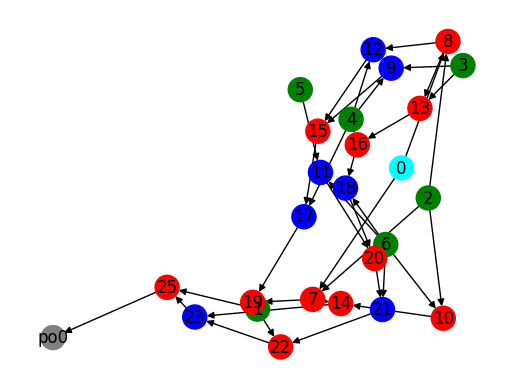

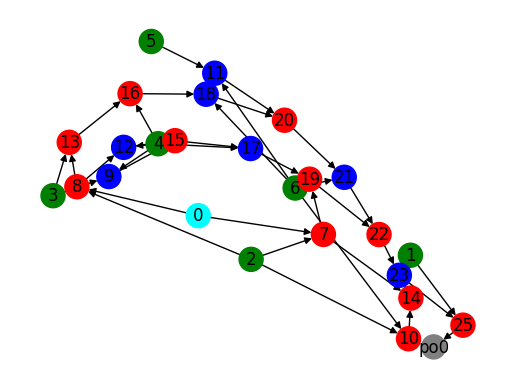

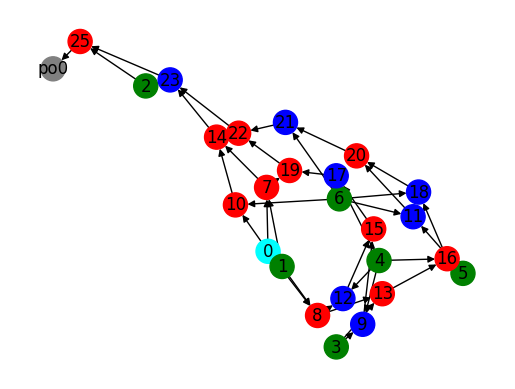

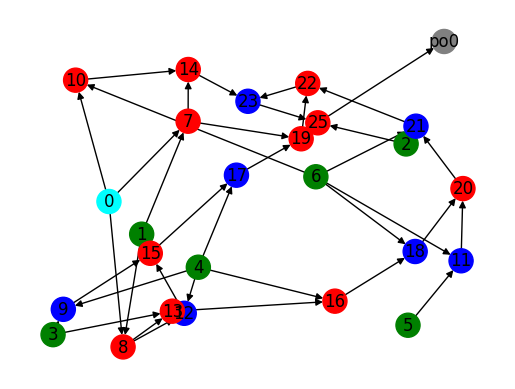

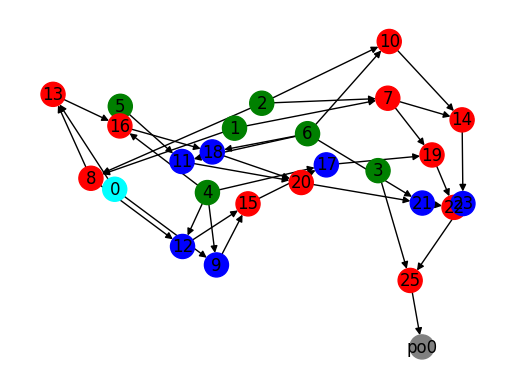

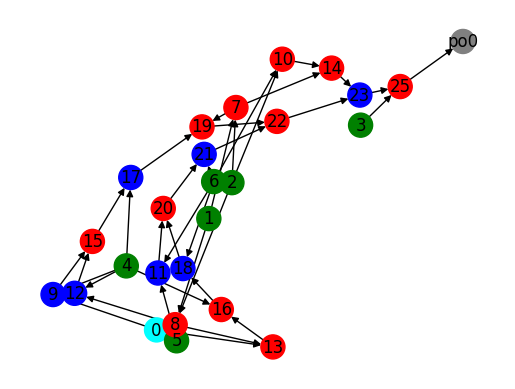

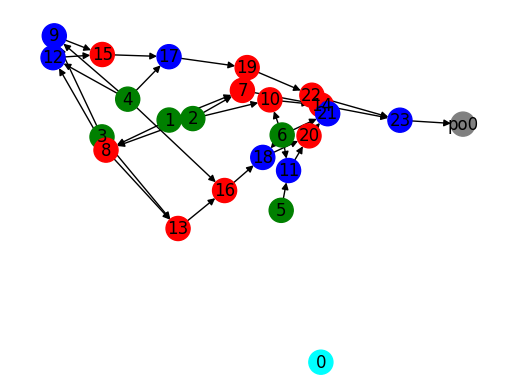

In [ ]:
import matplotlib.pyplot as plt
from nxag import _assign_color_map

def unit_prop(pyxag: PyXAG, input: str):
    from copy import deepcopy
    # given an input node, create two graphs one assuming input is TRUE and the other assuming input is False

    # f(x, y, ...) -> x * f(1, y, ...) (assuming x is true)
    pyxag_assume_true = PyXAG().from_nx(deepcopy(pyxag.G))
    # f(x, y, ...) -> ~x * f(0, y, ...) (assuming x is false)
    pyxag_assume_false = PyXAG().from_nx(deepcopy(pyxag.G))

    pyxag_assume_true = prop_signal(pyxag_assume_true, input, True)
    pyxag_assume_false = prop_signal(pyxag_assume_false, input, False)

    pyxag_assume_true.optimize_xag()
    pyxag_assume_false.optimize_xag()

    return pyxag_assume_true, pyxag_assume_false



def prop_signal(pyxag: PyXAG, input: str, assumption: bool):
    # replace all edges leaving input with the constant signal and add literal ANDed with previous output
    new_edges = []
    old_edges = []
   
    for (u, v, data) in pyxag.G.out_edges(input, data=True):
        # create new edges from 0 node to v
        # input assumption | edge is negated | 0 should be negated 
        #     True              True                False
        #     True              False               True    
        #     False             True                True   
        #     False             False               False
        new_edges.append(("0", v, {'negated': assumption ^ data['negated']}))
        old_edges.append((u, v))
        
    # remove old out_edges & insert new ones
    pyxag.G.remove_edges_from(old_edges)
    pyxag.G.add_edges_from(new_edges)

    # stitch together the assumtion with the new function
    old_output_edges = []
    new_output_edges = []

    final_and = str(pyxag.G.number_of_nodes())
    pyxag.G.add_node(final_and, label="AND", color="red")
    for (u, v, data) in pyxag.G.in_edges("po0", data=True):
        old_output_edges.append((u, v))

        # add edge from u to new AND node with input 
        new_output_edges.append((u, final_and, {'negated': data['negated']}))
        new_output_edges.append((input, final_and, {'negated': not assumption}))
        break

    pyxag.G.remove_edges_from(old_output_edges)
    pyxag.G.add_edges_from(new_output_edges)
    
    pyxag.G.add_edge(final_and, "po0", negated=False)
    pyxag.color_map = _assign_color_map(pyxag.G)
    return pyxag

for input in ["1", "2", "3"]:
    assume_true, assume_false = unit_prop(py_xag2, input)
    print("Propogating Input ", input)
    for pyxag in [assume_true, assume_false]:


        print(pyxag.sympy_expr())
        for node in pyxag.G.nodes:
            print(node, list(pyxag.G.out_edges(node, data=True)))

        fig, ax = plt.subplots()
        display(nx.draw(pyxag.G, ax=ax, node_color=pyxag.color_map, with_labels=True))

fig, ax = plt.subplots()
display(nx.draw(py_xag2.G, node_color=py_xag2.color_map, with_labels=True))
print(py_xag2.sympy_expr())

In [ ]:

# optimize new graph

py_xag_assume_3_is_true = PyXAG().from_nx(G_assume_true)
py_xag_assume_3_is_true.optimize_xag()
display(nx.draw(py_xag_assume_3_is_true.G, node_color=py_xag_assume_3_is_true.color_map, with_labels=True))


NameError: name 'G_assume_true' is not defined

# Graph Operations


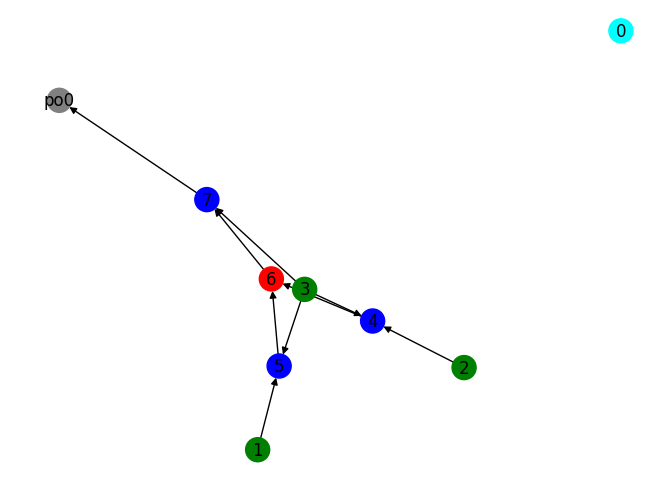

In [ ]:
xag = result.artifacts['xag']
color_map = result.artifacts['color_map']
nx.draw(xag, node_color=color_map, with_labels=True)

In [ ]:
def decompose(xag: nx.MultiDiGraph, input_nodes, level: int = 1):
    from copy import deepcopy
    from collections import deque

    """
    Recursively decompose graph and dynamically choose optimal subgraphs
    """

    # Base Case: level 3
    if level >= 3:
        return xag

    # strategy: Loop over each input variable and do Shannon expansion to create 2 graphs (DPLL)
    for input in input_nodes: 
        g1 = deepcopy(xag) # assume input is true

        queue = deque()
        queue.append((input, sympy.true))

        # explore children of input node
        for _, v, data in g1.out_edges(input, data=True):
            # check edge for negation and queue the propogating signal 
            outgoing_signal = sympy.false if data['negated'] else sympy.true
            
            # queue nodes with a new incoming constant signal
            queue.append((v, outgoing_signal))

        g1.remove_node(input)

        while not queue:
            node, insignal = queue.popleft()
            node_label = g1.nodes[node].get('label', 'po0')

            in_edge

            # given changed incoming signal, check for outgoing changes
            if node_label == "XOR":




decompose(xag, ["1"])


IndentationError: expected an indented block after 'if' statement on line 37 (1826051898.py, line 42)

# Benchmarking Expressions for Cliques

In [ ]:
import sympy.logic.boolalg as boolalg

for sym in expr.free_symbols:
    print(expr.count(sym))

7
2
9
5


In [ ]:
from collections import defaultdict

big_expr_str = "~(x5 & x6) & ~(x5 & x7) & ~(x1 ^ (x1 & ~x3 & ~x6 & ~x8)) & ~(~(x6 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))))) & ~((x1 & x2 & x3) ^ ((x5 ^ (x1 & x2 & x3)) & ~(x4 ^ (~(x4 ^ (x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3))))) & ~(x4 ^ (x1 & x2 & x3) ^ (x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3))))))))) & ~(x7 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))) & ~(x6 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x5 & ~(~x1 & ~x2 & ~x3 & ~x4)))))) & ~(x8 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))) & ~(x6 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x5 & ~(~x1 & ~x2 & ~x3 & ~x4)))) & ~(x7 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (~x1 & ~x2 & ~x3 & ~x4)))))))))" 


sympy_big_expr = sympy.parse_expr(big_expr_str)

#4 defaultdict(<class 'int'>, {1: 4}) {'x7': 3, 'x2': 26, 'x5': 9, 'x1': 28, 'x3': 49, 'x6': 8, 'x8': 2, 'x4': 17}

true_counts = 0
for t, v in boolalg.truth_table(sympy_big_expr, symbols("x1 x3 x4")):
    counts = defaultdict(int)
    for sym in v.free_symbols:
        counts[sym] += v.count(sym)
    print(v.args)
    print(counts)
    


print(f"{true_counts}/{2**8} ({true_counts / 2 **8:.02f}%)inputs")


(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6 & x7) & ~(x8 & ~(~(x2 & x5 & x6) & ~(x7 & (x6 ^ ((x5 ^ x6) & ~(x6 ^ ~x2))))))))
defaultdict(<class 'int'>, {x5: 5, x7: 3, x2: 3, x8: 1, x6: 6})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~(x6 ^ (~x6 & (x5 ^ x6)))))))))
defaultdict(<class 'int'>, {x5: 8, x7: 3, x2: 6, x8: 1, x6: 7})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~(x6 ^ (~x6 & (x5 ^ x6)))))))))
defaultdict(<class 'int'>, {x5: 8, x7: 3, x2: 6, x8: 1, x6: 7})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~x5 & ~x6)) & ~(x8 & ~(~x2 & ~x5 & ~x6 & ~x7))))
defaultdict(<class 'int'>, {x5: 6, x7: 3, x2: 4, x8: 1, x6: 4})
(~x6, ~x8, ~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x

In [ ]:
exp1 = sympy.parse_expr("a ^ (a & b)")
exp2 = sympy.parse_expr("a & ~b")

syms = symbols("a b c")
equal = True
for (t1, v1), (t2, v2) in zip(boolalg.truth_table(exp1, syms), boolalg.truth_table(exp2, syms)):
    print (v1, v2)

    if v1 != v2:
        equal = False

if equal == False:
    print("NOT Equivalent")
else: 
    print("Equivalent!")

False False
False False
False True
False True
True False
True False
False False
False False
NOT Equivalent


In [ ]:
sympy.Not(sympy.true)

False

In [ ]:
syms = sympy.symbols("x1 x2 x3")
expr = sympy.parse_expr("x1 & x2 & x3")
expr.to_anf()

x1 & x2 & x3

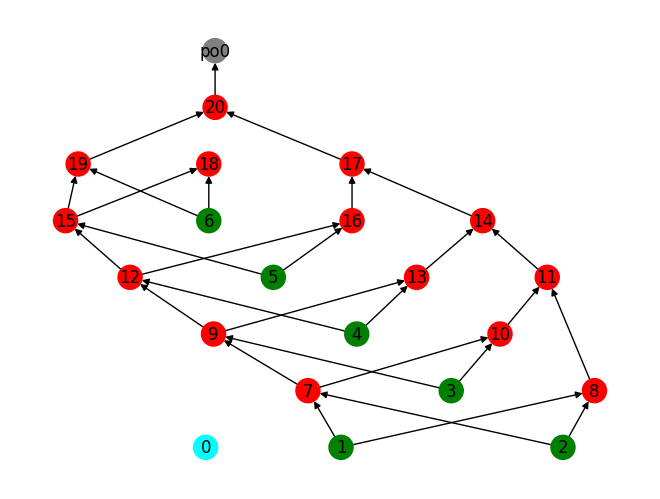

In [ ]:
from tweedledum.bool_function_compiler.decorators import circuit_input
from tweedledum.bool_function_compiler.quantum_circuit_function import QuantumCircuitFunction

from tweedledum import BitVec

@circuit_input(vertices= BitVec(6, "000000"))
def cardinality() -> BitVec(1):
    s_0_0 = BitVec(1, 1)
    s_0_1 = BitVec(1, 0)
    s_0_2 = BitVec(1, 0)
    s_1_0 = BitVec(1, 1)
    s_1_1 = s_0_1 | vertices[0] & s_0_0
    s_1_2 = BitVec(1, 0)
    s_2_0 = BitVec(1, 1)
    s_2_1 = s_1_1 | vertices[1] & s_1_0
    s_2_2 = s_1_2 | vertices[1] & s_1_1
    s_3_0 = BitVec(1, 1)
    s_3_1 = s_2_1 | vertices[2] & s_2_0
    s_3_2 = s_2_2 | vertices[2] & s_2_1
    s_4_0 = BitVec(1, 1)
    s_4_1 = s_3_1 | vertices[3] & s_3_0
    s_4_2 = s_3_2 | vertices[3] & s_3_1
    s_5_0 = BitVec(1, 1)
    s_5_1 = s_4_1 | vertices[4] & s_4_0
    s_5_2 = s_4_2 | vertices[4] & s_4_1
    s_6_0 = BitVec(1, 1)
    s_6_1 = s_5_1 | vertices[5] & s_5_0
    s_6_2 = s_5_2 | vertices[5] & s_5_1
    return s_6_2

qcf = QuantumCircuitFunction(cardinality)

pyxag_card = PyXAG().from_tweedledum_xag(qcf.logic_network())
pyxag.optimize_xag()

#nx.nx_agraph.write_dot(pyxag.G, 'test.dot')
pos = nx.drawing.nx_agraph.graphviz_layout(pyxag_card.G, prog='dot')
nx.draw(pyxag_card.G, pos, with_labels=True, node_color=pyxag_card.color_map)


In [ ]:
pyxag_card.sympy_expr()

~(~x1 & ~x2 & ~x3 & ~x4 & ~x5 & ~x6)

In [ ]:
for edge in pyxag_card.G.edges:
    print(edge, pyxag_card.G.edges[edge])

('1', '7', 0) {'negated': True}
('1', '8', 0) {'negated': False}
('2', '7', 0) {'negated': True}
('2', '8', 0) {'negated': False}
('3', '9', 0) {'negated': True}
('3', '10', 0) {'negated': False}
('4', '12', 0) {'negated': True}
('4', '13', 0) {'negated': False}
('5', '15', 0) {'negated': True}
('5', '16', 0) {'negated': False}
('6', '18', 0) {'negated': True}
('6', '19', 0) {'negated': False}
('7', '9', 0) {'negated': False}
('7', '10', 0) {'negated': True}
('8', '11', 0) {'negated': True}
('9', '12', 0) {'negated': False}
('9', '13', 0) {'negated': True}
('10', '11', 0) {'negated': True}
('11', '14', 0) {'negated': False}
('12', '15', 0) {'negated': False}
('12', '16', 0) {'negated': True}
('13', '14', 0) {'negated': True}
('14', '17', 0) {'negated': False}
('15', '18', 0) {'negated': False}
('15', '19', 0) {'negated': True}
('16', '17', 0) {'negated': True}
('17', '20', 0) {'negated': False}
('19', '20', 0) {'negated': True}
('20', 'po0', 0) {'negated': True}


In [86]:
expr = sympy.parse_expr("(x4 & x6) ^ (x1 & x3 & x4 & x6) ^ (x2 & x4 & x5 & x6) ^ (x1 & x2 & x3 & x4 & x5 & x6)")
sympy.simplify_logic(expr, form='cnf')


x4 & x6 & (~x1 | ~x3) & (~x2 | ~x5)